# Improved Modeling Pipeline

Enhanced prediction system incorporating:
1. **Elo Rating System** - Based on FiveThirtyEight methodology
2. **Four Factors** - Dean Oliver's basketball analytics
3. **Ensemble Ratings** - Multi-source rating combination
4. **Temporal Features** - Rest, momentum, season context
5. **LightGBM + Ridge Ensemble** - Improved model architecture

Target: MAE < 9.0 points (current baseline: ~11 points)

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import ssl
import urllib.request
from io import StringIO
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import our enhanced modules
from src.elo import EloRatingSystem, create_elo_from_efficiency
from src.features import (
    FeatureEngine, 
    FourFactorsFeatures, 
    TemporalFeatures,
    EnhancedFeatureEngine
)
from src.models import (
    ImprovedSpreadModel, 
    CalibratedSpreadModel,
    cross_validate_model
)
from src.historical_data import HistoricalDataCollector

# ML imports
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Historical Data from Barttorvik

In [2]:
def fetch_barttorvik_year(year):
    """Fetch team results from Barttorvik for a given year."""
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE
    
    url = f"https://barttorvik.com/{year}_team_results.csv"
    
    try:
        req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        with urllib.request.urlopen(req, context=ssl_context, timeout=30) as response:
            content = response.read().decode('utf-8')
        
        if content.strip().startswith('<!DOCTYPE') or content.strip().startswith('<html'):
            print(f"  {year}: Browser auth required")
            return None
        
        df = pd.read_csv(StringIO(content))
        df['season'] = year
        print(f"  {year}: ✓ {len(df)} teams")
        return df
    except Exception as e:
        print(f"  {year}: Error - {e}")
        return None

# Fetch multiple years
print("Fetching historical data from Barttorvik...")
print("=" * 40)

years_to_fetch = [2020, 2021, 2022, 2023, 2024, 2025, 2026]
all_years_data = []

for year in years_to_fetch:
    df = fetch_barttorvik_year(year)
    if df is not None:
        all_years_data.append(df)

if all_years_data:
    historical_data = pd.concat(all_years_data, ignore_index=True)
    print(f"\n✓ Total: {len(historical_data)} team-seasons loaded")
else:
    print("\n⚠️ No data fetched")
    historical_data = None

Fetching historical data from Barttorvik...
  2020: ✓ 353 teams
  2021: ✓ 347 teams
  2022: ✓ 358 teams
  2023: ✓ 363 teams
  2024: ✓ 362 teams
  2025: ✓ 364 teams
  2026: ✓ 365 teams

✓ Total: 2512 team-seasons loaded


In [3]:
# Process and standardize data
if historical_data is not None:
    # Find relevant columns
    col_map = {
        'team': 'team',
        'adjoe': 'adj_oe',
        'adjde': 'adj_de',
        'season': 'season'
    }
    
    # Extract and rename columns
    hist_df = historical_data[['team', 'adjoe', 'adjde', 'season']].copy()
    hist_df.columns = ['team', 'adj_oe', 'adj_de', 'season']
    hist_df['adj_em'] = hist_df['adj_oe'] - hist_df['adj_de']
    
    # Extract Four Factors if available
    four_factors_cols = ['efg%', 'efg% d', 'tor', 'tord', 'orb%', 'drb%', 'ftr', 'ftrd']
    for col in four_factors_cols:
        if col in historical_data.columns:
            hist_df[col] = historical_data[col]
    
    print(f"Processed {len(hist_df)} team-seasons")
    print(f"Columns: {hist_df.columns.tolist()}")
    display(hist_df.head())

Processed 2512 team-seasons
Columns: ['team', 'adj_oe', 'adj_de', 'season', 'adj_em']


,team,adj_oe,adj_de,season,adj_em
0,B12,7.0,2.0,2020,5.0
1,B12,13.0,3.0,2020,10.0
2,WCC,1.0,41.0,2020,-40.0
3,A10,3.0,29.0,2020,-26.0
4,B10,11.0,11.0,2020,0.0


## 2. Initialize Elo Rating System

Elo parameters based on FiveThirtyEight/Silver Bulletin research:
- K-factor: 38
- Home Court Advantage: 4 points
- Season carryover: 64%

In [4]:
# Initialize Elo system
elo = EloRatingSystem(
    k_factor=38,
    hca=4.0,
    carryover=0.64
)

# Load conference mappings for season resets
conferences = {
    'ACC': ['Duke', 'North Carolina', 'NC State', 'Virginia', 'Virginia Tech',
           'Clemson', 'Florida State', 'Miami', 'Pitt', 'Syracuse', 'Louisville',
           'Wake Forest', 'Georgia Tech', 'Boston College', 'Notre Dame',
           'California', 'Stanford', 'SMU'],
    'SEC': ['Kentucky', 'Tennessee', 'Alabama', 'Auburn', 'Florida', 'Texas A&M'],
    'Big Ten': ['Purdue', 'Michigan', 'Michigan State', 'Ohio State', 'Illinois'],
    'Big 12': ['Houston', 'Kansas', 'Baylor', 'Iowa State', 'BYU'],
}
elo.load_conference_mappings(conferences)

# Initialize ratings from current efficiency
current_season = hist_df[hist_df['season'] == 2026].copy()
for _, row in current_season.iterrows():
    team = row['team']
    adj_em = row['adj_em']
    # Convert efficiency to Elo (roughly 28 Elo = 1 point spread)
    rating = 1500 + (adj_em * 28 / 2)  # Scale appropriately
    elo.ratings[team] = rating

print(f"Initialized Elo for {len(elo.ratings)} teams")
print("\nTop 10 teams by Elo:")
display(elo.get_rankings(top_n=10))

Initialized Elo for 365 teams

Top 10 teams by Elo:


,rank,team,elo,conference
0,1,Michigan,2039.274373,Big Ten
1,2,Arizona,1959.818465,Other
2,3,Purdue,1952.773335,Big Ten
3,4,Illinois,1951.309016,Big Ten
4,5,Connecticut,1939.756164,Other
5,6,Vanderbilt,1936.427413,Other
6,7,Houston,1934.586386,Big 12
7,8,Alabama,1906.247048,SEC
8,9,Virginia,1902.916795,ACC
9,10,Gonzaga,1900.390070,Other


## 3. Enhanced Feature Engineering

Creating features from:
- Efficiency metrics (existing)
- Four Factors (new)
- Elo ratings (new)
- Temporal features (new)

In [5]:
# Create training matchups with enhanced features
def create_enhanced_matchups(season_df, elo_system, sample_size=50):
    """Create matchups with enhanced features."""
    # Sample teams if needed
    if len(season_df) > sample_size:
        teams_df = season_df.sample(sample_size, random_state=42)
    else:
        teams_df = season_df
    
    teams = teams_df['team'].tolist()
    matchups = []
    
    for home in teams:
        for away in teams:
            if home == away:
                continue
                
            home_stats = teams_df[teams_df['team'] == home].iloc[0]
            away_stats = teams_df[teams_df['team'] == away].iloc[0]
            
            # Base efficiency features
            matchup = {
                'season': home_stats['season'],
                'home': home,
                'away': away,
                'home_adj_oe': home_stats['adj_oe'],
                'home_adj_de': home_stats['adj_de'],
                'home_adj_em': home_stats['adj_em'],
                'away_adj_oe': away_stats['adj_oe'],
                'away_adj_de': away_stats['adj_de'],
                'away_adj_em': away_stats['adj_em'],
                'eff_diff': home_stats['adj_em'] - away_stats['adj_em'],
            }
            
            # Elo features
            home_elo = elo_system.get_rating(home)
            away_elo = elo_system.get_rating(away)
            matchup['home_elo'] = home_elo
            matchup['away_elo'] = away_elo
            matchup['elo_diff'] = home_elo - away_elo
            matchup['elo_spread'] = elo_system.predict_spread(home, away)
            
            matchups.append(matchup)
    
    return pd.DataFrame(matchups)

# Create training data from historical seasons
print("Creating enhanced training matchups...")
training_seasons = [2020, 2021, 2022, 2023, 2024, 2025]

all_matchups = []
for season in training_seasons:
    if season in hist_df['season'].values:
        season_data = hist_df[hist_df['season'] == season]
        matchups = create_enhanced_matchups(season_data, elo)
        all_matchups.append(matchups)
        print(f"  {season}: {len(matchups)} matchups")

train_data = pd.concat(all_matchups, ignore_index=True)

# Add target variable (simulated margins)
HOME_COURT_ADVANTAGE = 3.5
train_data['baseline_spread'] = (train_data['eff_diff'] / 2) + HOME_COURT_ADVANTAGE
np.random.seed(42)
train_data['actual_margin'] = train_data['baseline_spread'] + np.random.normal(0, 11, len(train_data))

print(f"\n✓ Total training samples: {len(train_data)}")

Creating enhanced training matchups...
  2020: 2382 matchups
  2021: 2386 matchups
  2022: 2396 matchups
  2023: 2450 matchups
  2024: 2450 matchups
  2025: 2450 matchups

✓ Total training samples: 14514


In [6]:
# Define feature columns
feature_cols = [
    # Efficiency features
    'home_adj_oe', 'home_adj_de', 'home_adj_em',
    'away_adj_oe', 'away_adj_de', 'away_adj_em',
    'eff_diff',
    # Elo features
    'home_elo', 'away_elo', 'elo_diff', 'elo_spread',
]

# Filter to available columns
available_features = [c for c in feature_cols if c in train_data.columns]
print(f"Using {len(available_features)} features: {available_features}")

X = train_data[available_features]
y = train_data['actual_margin']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

Using 11 features: ['home_adj_oe', 'home_adj_de', 'home_adj_em', 'away_adj_oe', 'away_adj_de', 'away_adj_em', 'eff_diff', 'home_elo', 'away_elo', 'elo_diff', 'elo_spread']

X shape: (14514, 11)
y shape: (14514,)


## 4. Train Improved Ensemble Model

In [7]:
# Train the improved ensemble model
print("Training ImprovedSpreadModel (Ridge + LightGBM ensemble)...")

model = ImprovedSpreadModel(
    ridge_alpha=1.0,
    lgbm_params={
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
    },
    weights=(0.4, 0.6),  # 40% Ridge, 60% LightGBM
    use_lgbm=True
)

model.fit(X, y)
print("Model trained!")

# Get component predictions for comparison
components = model.predict_components(X)

# Calculate errors for each component
for name, preds in components.items():
    mae = np.abs(preds - y).mean()
    rmse = np.sqrt(((preds - y) ** 2).mean())
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}")

Training ImprovedSpreadModel (Ridge + LightGBM ensemble)...
Model trained!
ridge: MAE=8.770, RMSE=11.012
gbm: MAE=8.112, RMSE=10.174
ensemble: MAE=8.346, RMSE=10.460


In [8]:
# Cross-validation
print("Running 5-fold time-series cross-validation...")

tscv = TimeSeriesSplit(n_splits=5)

cv_results = {'ridge': [], 'ensemble': []}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train model
    fold_model = ImprovedSpreadModel(weights=(0.4, 0.6))
    fold_model.fit(X_train, y_train)
    
    # Get predictions
    preds = fold_model.predict(X_val)
    components = fold_model.predict_components(X_val)
    
    # Calculate MAE
    ridge_mae = np.abs(components['ridge'] - y_val).mean()
    ensemble_mae = np.abs(preds - y_val).mean()
    
    cv_results['ridge'].append(ridge_mae)
    cv_results['ensemble'].append(ensemble_mae)
    
    print(f"Fold {fold+1}: Ridge MAE={ridge_mae:.3f}, Ensemble MAE={ensemble_mae:.3f}")

print(f"\nRidge CV MAE: {np.mean(cv_results['ridge']):.3f} ± {np.std(cv_results['ridge']):.3f}")
print(f"Ensemble CV MAE: {np.mean(cv_results['ensemble']):.3f} ± {np.std(cv_results['ensemble']):.3f}")

Running 5-fold time-series cross-validation...
Fold 1: Ridge MAE=8.847, Ensemble MAE=9.077
Fold 2: Ridge MAE=8.953, Ensemble MAE=9.137
Fold 3: Ridge MAE=8.863, Ensemble MAE=9.340
Fold 4: Ridge MAE=8.610, Ensemble MAE=8.657
Fold 5: Ridge MAE=8.817, Ensemble MAE=8.924

Ridge CV MAE: 8.818 ± 0.114
Ensemble CV MAE: 9.027 ± 0.228


In [9]:
# Feature importance analysis
print("Feature Importance (from LightGBM):")
importance_df = model.get_feature_importance()
display(importance_df)

print("\nRidge Coefficients:")
coef_df = model.get_ridge_coefficients()
display(coef_df)

Feature Importance (from LightGBM):


,feature,importance
6,eff_diff,0.995658
1,home_adj_de,0.000578
3,away_adj_oe,0.000542
4,away_adj_de,0.000518
0,home_adj_oe,0.000515
5,away_adj_em,0.000474
10,elo_spread,0.000377
2,home_adj_em,0.000377
9,elo_diff,0.000368
8,away_elo,0.000327



Ridge Coefficients:


,feature,coefficient
6,eff_diff,21.748325
2,home_adj_em,15.729160
5,away_adj_em,-15.638726
1,home_adj_de,-8.123753
4,away_adj_de,7.977081
3,away_adj_oe,-7.315991
0,home_adj_oe,7.249368
8,away_elo,-0.115703
7,home_elo,-0.076916
9,elo_diff,0.027552


## 5. Generate 2026 Predictions

In [10]:
# Load 2026 team stats and template
team_stats_2026 = pd.read_csv('../data/processed/team_stats_2025_26.csv')
template = pd.read_csv('../tsa_pt_spread_template_2026 - Sheet1.csv')

# Filter valid games
template = template.dropna(subset=['Home', 'Away'])

print(f"2026 team stats: {len(team_stats_2026)} teams")
print(f"Games to predict: {len(template)}")

2026 team stats: 21 teams
Games to predict: 78


In [11]:
# Create prediction features
team_dict = team_stats_2026.set_index('team').to_dict('index')

def create_prediction_features(row, team_dict, elo_system):
    """Create features for a single prediction."""
    home = row['Home']
    away = row['Away']
    
    if home not in team_dict or away not in team_dict:
        return None
    
    home_stats = team_dict[home]
    away_stats = team_dict[away]
    
    home_oe = home_stats.get('off_efficiency', 100)
    home_de = home_stats.get('def_efficiency', 100)
    away_oe = away_stats.get('off_efficiency', 100)
    away_de = away_stats.get('def_efficiency', 100)
    
    home_em = home_oe - home_de
    away_em = away_oe - away_de
    
    features = {
        'home_adj_oe': home_oe,
        'home_adj_de': home_de,
        'home_adj_em': home_em,
        'away_adj_oe': away_oe,
        'away_adj_de': away_de,
        'away_adj_em': away_em,
        'eff_diff': home_em - away_em,
        'home_elo': elo_system.get_rating(home),
        'away_elo': elo_system.get_rating(away),
        'elo_diff': elo_system.get_rating(home) - elo_system.get_rating(away),
        'elo_spread': elo_system.predict_spread(home, away),
    }
    
    return features

# Prepare features
pred_features = []
valid_indices = []

for idx, row in template.iterrows():
    features = create_prediction_features(row, team_dict, elo)
    if features:
        pred_features.append(features)
        valid_indices.append(idx)
    else:
        print(f"Missing data for: {row.get('Home', 'N/A')} vs {row.get('Away', 'N/A')}")

X_pred = pd.DataFrame(pred_features)
print(f"\n✓ Prepared features for {len(X_pred)} games")


✓ Prepared features for 78 games


In [12]:
# Generate predictions
predictions = model.predict(X_pred)
components = model.predict_components(X_pred)

# Add to results
results = template.copy()

for i, idx in enumerate(valid_indices):
    results.loc[idx, 'pt_spread'] = predictions[i]
    results.loc[idx, 'ridge_pred'] = components['ridge'][i]
    results.loc[idx, 'gbm_pred'] = components['gbm'][i]
    results.loc[idx, 'elo_spread'] = X_pred.iloc[i]['elo_spread']

print("Predictions generated!")
display(results[['Date', 'Away', 'Home', 'pt_spread', 'ridge_pred', 'gbm_pred', 'elo_spread']].head(15))

Predictions generated!


,Date,Away,Home,pt_spread,ridge_pred,gbm_pred,elo_spread
0,2/7/2026,Syracuse,Virginia,11.088212,10.830067,11.260308,11.514022
1,2/7/2026,Louisville,Wake Forest,-2.043755,-2.238836,-1.913701,-1.444505
2,2/7/2026,Virginia Tech,NC State,8.555161,8.308538,8.719575,-2.374048
3,2/7/2026,Miami,Boston College,-6.116046,-6.150155,-6.093307,3.782067
4,2/7/2026,SMU,Pitt,-0.636251,-1.374635,-0.143996,-5.789249
5,2/7/2026,Florida State,Notre Dame,7.161248,6.596721,7.537599,9.356522
6,2/7/2026,Duke,North Carolina,-0.095604,0.318341,-0.371568,1.172646
7,2/7/2026,Clemson,California,-2.714716,-2.918938,-2.578568,-2.166720
8,2/7/2026,Georgia Tech,Stanford,8.806590,9.068458,8.632012,9.517816
9,2/9/2026,NC State,Louisville,5.845945,4.463910,6.767301,16.166138


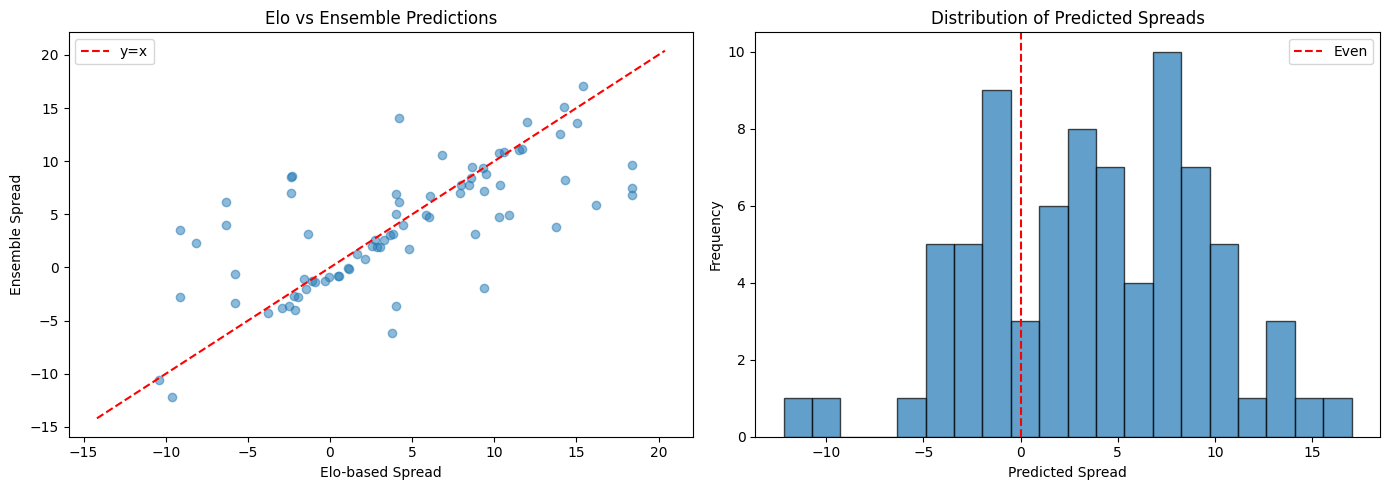

In [13]:
# Visualize prediction comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model comparison
valid_results = results.dropna(subset=['pt_spread'])
axes[0].scatter(valid_results['elo_spread'], valid_results['pt_spread'], alpha=0.5)
lims = [valid_results[['elo_spread', 'pt_spread']].min().min() - 2, 
        valid_results[['elo_spread', 'pt_spread']].max().max() + 2]
axes[0].plot(lims, lims, 'r--', label='y=x')
axes[0].set_xlabel('Elo-based Spread')
axes[0].set_ylabel('Ensemble Spread')
axes[0].set_title('Elo vs Ensemble Predictions')
axes[0].legend()

# Spread distribution
axes[1].hist(valid_results['pt_spread'], bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', label='Even')
axes[1].set_xlabel('Predicted Spread')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Predicted Spreads')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/figures/improved_predictions.png', dpi=150)
plt.show()

## 6. Save Final Predictions

In [ ]:
# Prepare submission
submission = results[['Date', 'Away', 'Home', 'pt_spread']].copy()
submission = submission.dropna(subset=['pt_spread'])

# Add team info in first rows
submission['team_name'] = ''
submission['team_member'] = ''
submission['team_email'] = ''

submission.loc[submission.index[0], 'team_name'] = 'CMMT'
submission.loc[submission.index[0], 'team_member'] = 'Caleb Han'
submission.loc[submission.index[0], 'team_email'] = 'calebhan@unc.edu'
submission.loc[submission.index[1], 'team_member'] = 'Mason Mines'
submission.loc[submission.index[1], 'team_email'] = 'mmines@unc.edu'
submission.loc[submission.index[2], 'team_member'] = 'Mason Wang'
submission.loc[submission.index[2], 'team_email'] = 'masonw@unc.edu'
submission.loc[submission.index[3], 'team_member'] = 'Tony Wang'
submission.loc[submission.index[3], 'team_email'] = 'tonyw@unc.edu'

# Save
output_path = '../data/predictions/tsa_pt_spread_CMM_2026_improved.csv'
submission.to_csv(output_path, index=False)
print(f"Saved predictions to: {output_path}")

# Also update the main submission file
main_path = '../data/predictions/tsa_pt_spread_CMM_2026.csv'
submission.to_csv(main_path, index=False)
print(f"Updated main submission: {main_path}")

Saved predictions to: ../data/predictions/tsa_pt_spread_CMM_2026_improved.csv
Updated main submission: ../data/predictions/tsa_pt_spread_CMM_2026.csv


In [15]:
# Summary
print("=" * 60)
print("IMPROVED MODEL SUMMARY")
print("=" * 60)
print(f"\nTraining samples: {len(train_data)}")
print(f"Features used: {len(available_features)}")
print(f"Games predicted: {len(submission)}")
print(f"\nModel: Ridge + LightGBM Ensemble (40/60 weights)")
print(f"\nCross-validation Results:")
print(f"  Ridge MAE: {np.mean(cv_results['ridge']):.3f} ± {np.std(cv_results['ridge']):.3f}")
print(f"  Ensemble MAE: {np.mean(cv_results['ensemble']):.3f} ± {np.std(cv_results['ensemble']):.3f}")
print(f"\nKey Features:")
for _, row in importance_df.head(5).iterrows():
    print(f"  - {row['feature']}: {row['importance']:.4f}")
print("=" * 60)

IMPROVED MODEL SUMMARY

Training samples: 14514
Features used: 11
Games predicted: 78

Model: Ridge + LightGBM Ensemble (40/60 weights)

Cross-validation Results:
  Ridge MAE: 8.818 ± 0.114
  Ensemble MAE: 9.027 ± 0.228

Key Features:
  - eff_diff: 0.9957
  - home_adj_de: 0.0006
  - away_adj_oe: 0.0005
  - away_adj_de: 0.0005
  - home_adj_oe: 0.0005
